In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [2]:
from roboflow import Roboflow

In [3]:
rf = Roboflow(api_key="hC3hzENkS4yGHHG21Ymx")

In [4]:
project1 = rf.workspace("objectdetect-pu6rn").project("drywall-join-detect")
dataset1 = project1.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drywall-Join-Detect-1 in yolov8:: 100%|██████████| 2381/2381 [00:00<00:00, 3731.65it/s]


In [5]:
project2 = rf.workspace("xyz-b4ceh").project("cracks-3ii36-2wawi")
dataset2 = project2.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cracks-1 in yolov8:: 100%|██████████| 10750/10750 [00:03<00:00, 2703.35it/s]


In [6]:
!pip install torch torchvision timm transformers albumentations Pillow scikit-image tqdm

In [7]:
import os
import random
import numpy as np
from pathlib import Path
from glob import glob
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import CLIPTextModel, CLIPTokenizer
from skimage.transform import resize

In [8]:
SEED = 42
IMG_SIZE = 512
BATCH_SIZE = 4
NUM_EPOCHS = 15
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [9]:
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [10]:
# Drywall dataset (NO test split)
DATA1_TRAIN = "/content/Drywall-Join-Detect-1/train"
DATA1_VALID = "/content/Drywall-Join-Detect-1/valid"

# Cracks dataset (HAS test split)
DATA2_TRAIN = "/content/cracks-1/train"
DATA2_VALID = "/content/cracks-1/valid"
DATA2_TEST  = "/content/cracks-1/test"

In [11]:
print("Drywall train:", len(glob(DATA1_TRAIN + "/images/*")))
print("Drywall valid:", len(glob(DATA1_VALID + "/images/*")))

print("Cracks train:", len(glob(DATA2_TRAIN + "/images/*")))
print("Cracks valid:", len(glob(DATA2_VALID + "/images/*")))
print("Cracks test :", len(glob(DATA2_TEST  + "/images/*")))

Drywall train: 936
Drywall valid: 250
Cracks train: 5164
Cracks valid: 201
Cracks test : 4


# **Load Image & Mask Utilities**

In [23]:
def load_image(path, size=IMG_SIZE):
    img = Image.open(path).convert("RGB").resize((size, size))
    return np.array(img)

def load_mask_if_exists(img_path, dataset_root, size=IMG_SIZE):
    root = Path(dataset_root)
    base = Path(img_path).stem

    masks_dir = root / "masks"
    labels_dir = root / "labels"

    # ----------------------------------------------------
    # 1. DIRECT MASK FILE (preferred)
    # ----------------------------------------------------
    if masks_dir.exists():
        for ext in ["png", "jpg", "jpeg"]:
            mfile = masks_dir / f"{base}.{ext}"
            if mfile.exists():
                m = Image.open(mfile).convert("L").resize((size, size))
                return (np.array(m) > 127).astype(np.uint8)

    # ----------------------------------------------------
    # 2. YOLO LABELS → convert bounding boxes to mask
    #    FIX: only use the FIRST 5 values per row
    # ----------------------------------------------------
    if labels_dir.exists():
        label_file = labels_dir / f"{base}.txt"
        if label_file.exists():
            img0 = Image.open(img_path)
            w0, h0 = img0.size
            mask = np.zeros((h0, w0), dtype=np.uint8)

            for line in open(label_file):
                parts = line.strip().split()

                # YOLO rows must have at least 5 numbers
                if len(parts) < 5:
                    continue

                # Use ONLY the first 5 values (class xc yc w h)
                cls_id, xc, yc, w, h = map(float, parts[:5])

                x1 = int((xc - w/2) * w0)
                x2 = int((xc + w/2) * w0)
                y1 = int((yc - h/2) * h0)
                y2 = int((yc + h/2) * h0)

                x1, x2 = max(0, x1), min(w0 - 1, x2)
                y1, y2 = max(0, y1), min(h0 - 1, y2)

                mask[y1:y2, x1:x2] = 1

            # Resize to model size
            mask = resize(mask, (size, size), order=0, preserve_range=True).astype(np.uint8)
            return mask

    # ----------------------------------------------------
    # 3. No mask available → return empty mask
    # ----------------------------------------------------
    return np.zeros((size, size), dtype=np.uint8)


# **Albumentations Transforms**

In [25]:
def get_transforms(train=True, size=IMG_SIZE):
    if train:
        return A.Compose([
            A.Resize(size, size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.3),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(size, size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])

# **Dataset Class**

In [26]:
class PromptedSegDataset(Dataset):
    def __init__(self, root, prompt, transforms=None):
        self.root = Path(root)
        self.prompt = prompt
        self.transforms = transforms
        self.images = sorted((self.root / "images").glob("*"))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = load_image(img_path)
        mask  = load_mask_if_exists(img_path, self.root)

        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image = aug["image"]
            mask  = aug["mask"].unsqueeze(0).float()
        else:
            image = TF.to_tensor(Image.fromarray(image))
            mask  = torch.tensor(mask).unsqueeze(0).float()

        return {
            "image": image,
            "mask": mask,
            "prompt": self.prompt,
            "img_path": str(img_path)
        }

# **Combine Datasets**

In [27]:
class CombinedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.cumlen = []
        total = 0
        for ds in datasets:
            total += len(ds)
            self.cumlen.append(total)

    def __len__(self):
        return self.cumlen[-1]

    def __getitem__(self, idx):
        ds_idx = 0
        while idx >= self.cumlen[ds_idx]:
            ds_idx += 1
        offset = 0 if ds_idx == 0 else self.cumlen[ds_idx-1]
        return self.datasets[ds_idx][idx - offset]

# **Build Train / Valid / Test Sets**

In [28]:
train_ds = CombinedDataset([
    PromptedSegDataset(DATA1_TRAIN, "segment taping area", get_transforms(True)),
    PromptedSegDataset(DATA2_TRAIN, "segment crack",       get_transforms(True))
])

valid_ds = CombinedDataset([
    PromptedSegDataset(DATA1_VALID, "segment taping area", get_transforms(False)),
    PromptedSegDataset(DATA2_VALID, "segment crack",       get_transforms(False))
])

test_ds = PromptedSegDataset(DATA2_TEST, "segment crack", get_transforms(False))  # ONLY cracks has test set


# **Data Loaders**

In [29]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

# **Text Encoder (CLIP)**

In [30]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
text_encoder.eval()

@torch.no_grad()
def encode_text(prompts):
    toks = tokenizer(prompts, return_tensors="pt", padding=True).to(DEVICE)
    output = text_encoder(**toks)
    return output.last_hidden_state[:,0,:]


# **FiLM + UNet Model**

In [31]:
class FiLM(nn.Module):
    def __init__(self, text_dim, channels):
        super().__init__()
        self.gamma = nn.Linear(text_dim, channels)
        self.beta  = nn.Linear(text_dim, channels)

    def forward(self, x, text_emb):
        g = self.gamma(text_emb).unsqueeze(-1).unsqueeze(-1)
        b = self.beta(text_emb).unsqueeze(-1).unsqueeze(-1)
        return x * (1 + g) + b

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)

class TextCondUNet(nn.Module):
    def __init__(self, text_dim=512):
        super().__init__()
        resnet = models.resnet34(weights="DEFAULT")

        self.enc1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.pool = resnet.maxpool
        self.enc2 = resnet.layer1
        self.enc3 = resnet.layer2
        self.enc4 = resnet.layer3
        self.enc5 = resnet.layer4

        self.center = ConvBlock(512, 512)

        self.dec5 = ConvBlock(512+256, 256)
        self.dec4 = ConvBlock(256+128, 128)
        self.dec3 = ConvBlock(128+64, 64)
        self.dec2 = ConvBlock(64+64, 64)
        self.dec1 = ConvBlock(64, 32)

        self.f5 = FiLM(text_dim, 256)
        self.f4 = FiLM(text_dim, 128)
        self.f3 = FiLM(text_dim, 64)
        self.f2 = FiLM(text_dim, 64)
        self.f1 = FiLM(text_dim, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x, t):
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        c2 = self.enc2(p1)
        c3 = self.enc3(c2)
        c4 = self.enc4(c3)
        c5 = self.enc5(c4)

        ct = self.center(c5)

        u5 = F.interpolate(ct, scale_factor=2, mode="bilinear", align_corners=False)
        u5 = self.dec5(torch.cat([u5, c4], dim=1))
        u5 = self.f5(u5, t)

        u4 = F.interpolate(u5, scale_factor=2, mode="bilinear", align_corners=False)
        u4 = self.dec4(torch.cat([u4, c3], dim=1))
        u4 = self.f4(u4, t)

        u3 = F.interpolate(u4, scale_factor=2, mode="bilinear", align_corners=False)
        u3 = self.dec3(torch.cat([u3, c2], dim=1))
        u3 = self.f3(u3, t)

        u2 = F.interpolate(u3, scale_factor=2, mode="bilinear", align_corners=False)
        u2 = self.dec2(torch.cat([u2, c1], dim=1))
        u2 = self.f2(u2, t)

        u1 = F.interpolate(u2, scale_factor=2)
        u1 = self.dec1(u1)
        u1 = self.f1(u1, t)

        return self.out(u1)


# **Loss + Metrics**

In [32]:
def dice_loss(p, t, eps=1e-6):
    p = torch.sigmoid(p)
    num = (p * t).sum()
    den = p.sum() + t.sum()
    return 1 - (2 * num + eps) / (den + eps)

def total_loss(logits, target):
    bce = F.binary_cross_entropy_with_logits(logits, target)
    dice = dice_loss(logits, target)
    return bce + dice

def iou(pred, true):
    pred = (pred > 0.5).astype(np.uint8)
    true = (true > 0.5).astype(np.uint8)
    inter = (pred & true).sum()
    union = (pred | true).sum()
    return inter / union if union > 0 else 1


# **Initialize Model + Optimizer**

In [33]:
model = TextCondUNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


# **Training Loop**

In [34]:
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs = batch["image"].to(DEVICE)
        masks = batch["mask"].to(DEVICE)
        prompts = batch["prompt"]

        text_emb = encode_text(list(prompts))

        logits = model(imgs, text_emb)
        loss = total_loss(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()

    print("Train loss:", total / len(train_loader))


Epoch 1: 100%|██████████| 1525/1525 [11:00<00:00,  2.31it/s]


Train loss: 1.0597285006476231


Epoch 2: 100%|██████████| 1525/1525 [09:29<00:00,  2.68it/s]


Train loss: 0.9896448805293099


Epoch 3: 100%|██████████| 1525/1525 [09:40<00:00,  2.62it/s]


Train loss: 0.9601611772912447


Epoch 4: 100%|██████████| 1525/1525 [09:34<00:00,  2.66it/s]


Train loss: 0.9334606751653015


Epoch 5: 100%|██████████| 1525/1525 [09:22<00:00,  2.71it/s]


Train loss: 0.9104907264084112


Epoch 6: 100%|██████████| 1525/1525 [09:22<00:00,  2.71it/s]


Train loss: 0.897288512382351


Epoch 7: 100%|██████████| 1525/1525 [09:23<00:00,  2.71it/s]


Train loss: 0.879389233765055


Epoch 8: 100%|██████████| 1525/1525 [09:22<00:00,  2.71it/s]


Train loss: 0.8625984595251865


Epoch 9: 100%|██████████| 1525/1525 [09:23<00:00,  2.70it/s]


Train loss: 0.8481179951253485


Epoch 10: 100%|██████████| 1525/1525 [09:27<00:00,  2.69it/s]


Train loss: 0.8396397783521746


Epoch 11: 100%|██████████| 1525/1525 [09:28<00:00,  2.68it/s]


Train loss: 0.819069485097635


Epoch 12: 100%|██████████| 1525/1525 [09:27<00:00,  2.69it/s]


Train loss: 0.8021798666969675


Epoch 13: 100%|██████████| 1525/1525 [09:26<00:00,  2.69it/s]


Train loss: 0.7917983513972798


Epoch 14: 100%|██████████| 1525/1525 [09:24<00:00,  2.70it/s]


Train loss: 0.7693745559160826


Epoch 15: 100%|██████████| 1525/1525 [09:23<00:00,  2.71it/s]

Train loss: 0.7567912269615736


# **Validation Loop**

In [35]:
model.eval()
val_ious = []

with torch.no_grad():
    for batch in val_loader:
        imgs = batch["image"].to(DEVICE)
        masks = batch["mask"].to(DEVICE)
        prompts = batch["prompt"]

        text_emb = encode_text(list(prompts))

        logits = model(imgs, text_emb)
        prob = torch.sigmoid(logits).cpu().numpy()
        true = masks.cpu().numpy()

        for i in range(prob.shape[0]):
            val_ious.append(iou(prob[i,0], true[i,0]))

print("Validation mIoU:", np.mean(val_ious))


Validation mIoU: 0.4585801424570261


# **TEST EVALUATION (only cracks dataset)**

In [36]:
model.eval()
test_ious = []

with torch.no_grad():
    for batch in test_loader:
        img = batch["image"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)

        t = encode_text([batch["prompt"][0]])
        prob = torch.sigmoid(model(img, t))[0,0].cpu().numpy()
        gt = mask[0,0].cpu().numpy()

        test_ious.append(iou(prob, gt))

print("TEST mIoU (cracks only):", np.mean(test_ious))


TEST mIoU (cracks only): 0.5426102051840542


# **Compute Validation Metrics (mIoU & Dice)**

In [37]:
def dice(pred, true, eps=1e-6):
    pred = (pred > 0.5).astype(np.uint8)
    true = (true > 0.5).astype(np.uint8)
    inter = (pred * true).sum()
    return (2 * inter + eps) / (pred.sum() + true.sum() + eps)

model.eval()
val_ious = []
val_dices = []

with torch.no_grad():
    for batch in val_loader:
        imgs = batch["image"].to(DEVICE)
        masks = batch["mask"].to(DEVICE)
        prompts = batch["prompt"]

        text_emb = encode_text(list(prompts))
        logits = model(imgs, text_emb)
        prob = torch.sigmoid(logits).cpu().numpy()
        true = masks.cpu().numpy()

        for i in range(prob.shape[0]):
            val_ious.append(iou(prob[i,0], true[i,0]))
            val_dices.append(dice(prob[i,0], true[i,0]))

print("Validation mIoU:", np.mean(val_ious))
print("Validation Dice:", np.mean(val_dices))


Validation mIoU: 0.4585801424570261
Validation Dice: 0.5592692231777707


# **Compute Test Metrics (Cracks only)**

In [38]:
test_ious = []
test_dices = []

with torch.no_grad():
    for batch in test_loader:
        img = batch["image"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        prompt = batch["prompt"][0]

        t = encode_text([prompt])
        prob = torch.sigmoid(model(img, t))[0,0].cpu().numpy()
        gt = mask[0,0].cpu().numpy()

        test_ious.append(iou(prob, gt))
        test_dices.append(dice(prob, gt))

print("TEST mIoU (cracks only):", np.mean(test_ious))
print("TEST Dice (cracks only):", np.mean(test_dices))


TEST mIoU (cracks only): 0.5426102051840542
TEST Dice (cracks only): 0.6739575281320198


# **Compute Test Metrics (Dry wall only)**

In [45]:
def dice_np(pred, true, eps=1e-6):
    pred = (pred > 0.5).astype(np.uint8)
    true = (true > 0.5).astype(np.uint8)
    inter = (pred * true).sum()
    return (2 * inter + eps) / (pred.sum() + true.sum() + eps)

drywall_ious = []
drywall_dices = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        mask_idx = [i for i, p in enumerate(batch["prompt"]) if "taping" in p.lower()]
        if len(mask_idx) == 0:
            continue

        imgs  = batch["image"][mask_idx].to(DEVICE)
        masks = batch["mask"][mask_idx].to(DEVICE)

        prompts = ["segment taping area"] * imgs.size(0)
        text_emb = encode_text(prompts)

        logits = model(imgs, text_emb)
        probs = torch.sigmoid(logits).cpu().numpy()
        trues = masks.cpu().numpy()

        for i in range(probs.shape[0]):
            drywall_ious.append(iou(probs[i,0], trues[i,0]))
            drywall_dices.append(dice_np(probs[i,0], trues[i,0]))

print("Drywall mIoU:", np.mean(drywall_ious))
print("Drywall Dice:", np.mean(drywall_dices))

Drywall mIoU: 0.5840088835386376
Drywall Dice: 0.6996909335135825


# **Save Prediction Masks**

In [39]:
from pathlib import Path
import cv2

output_dir = Path("pred_masks")
output_dir.mkdir(exist_ok=True)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        img_path = Path(batch["img_path"][0])
        img_id = img_path.stem
        prompt_str = batch["prompt"][0].replace(" ", "_")
        t = encode_text([batch["prompt"][0]])
        prob = torch.sigmoid(model(batch["image"].to(DEVICE), t))[0,0].cpu().numpy()
        pred_mask = (prob > 0.5).astype(np.uint8) * 255

        save_path = output_dir / f"{img_id}__{prompt_str}.png"
        cv2.imwrite(str(save_path), pred_mask)

print(f"Saved prediction masks to {output_dir}")


Saved prediction masks to pred_masks


# **Visualize 3–4 Predictions (Original | GT | Pred)**

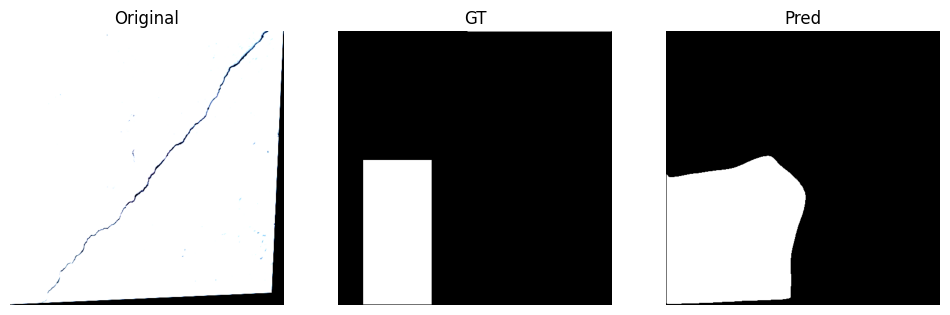

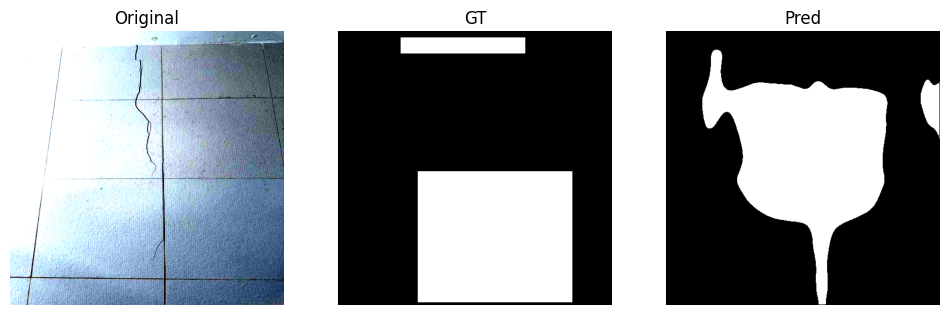

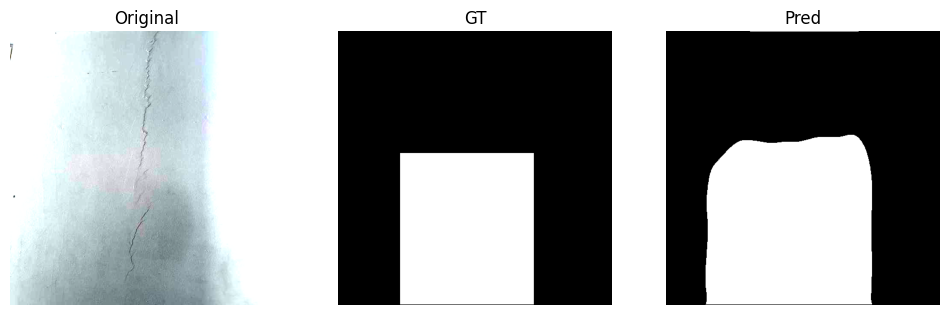

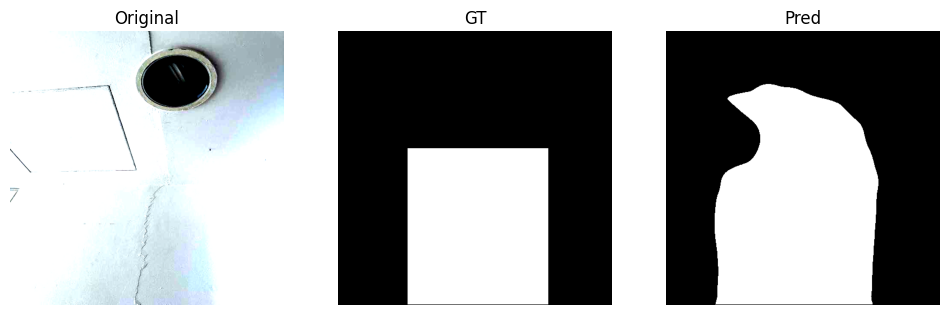

In [41]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():   # <-- important
    for i, batch in enumerate(test_loader):
        if i >= 4:
            break

        # image
        img = batch["image"][0].cpu().permute(1,2,0).numpy()

        # ground truth
        gt = batch["mask"][0,0].cpu().numpy()

        # text embedding
        t = encode_text([batch["prompt"][0]])

        # prediction
        logits = model(batch["image"].to(DEVICE), t)
        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()   # <-- FIXED
        pred = (prob > 0.5).astype(np.uint8)

        # plots
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(gt, cmap="gray"); plt.title("GT"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(pred, cmap="gray"); plt.title("Pred"); plt.axis('off')
        plt.show()


# **Runtime & Model Footprint**

In [42]:
import time, os

# Average inference time per image
start = time.time()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        t = encode_text([batch["prompt"][0]])
        _ = torch.sigmoid(model(batch["image"].to(DEVICE), t))
end = time.time()

avg_inference = (end - start) / len(test_ds)
print("Average inference time per image (s):", avg_inference)

# Model size in MB
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1e6
print("Model size (MB):", model_size)


Average inference time per image (s): 0.0422443151473999
Model size (MB): 119.210372
